In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Sampling 1D Gaussian via MCMC using Metropolois-Hastings 

We want to sample from the 1D Guassian distribution. 
To this end, we consider the _unnormalised_ (zero centered, i.e. $\mu = 0$) Guassian distribution 

$$\rho(x) = e^{- x^2 / (2 \sigma^2)}$$

Since normalisations are hard to get right using MCMC, it is better to compute moments.
For simplicity, we focus on 

$$ \langle x^2 \rangle = \frac{\int\ \rho(x) x^2 \ dx}{\int\ \rho(x)\ dx} = \mu^2 + \sigma^2 = \sigma^2$$

Idea:
1. use MCMC to sample a bunch of points $X = \{x_i\}_{i=1}^n$ from $\rho$ 
2. compute $\mathbb E[x^2] = \frac{1}{n} \sum_i x_i^2$

In [15]:
def rho(x:float,sigma:float = 1) -> float:
    """
    Unnormalised Gaussian distribution
    """
    return np.exp( -x**2 / (2*sigma**2) )
    
def MCMC(xi:float,rho,N:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute transition probabilities T for a 1D Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x(i)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: Markov Chain sampled from rho and the acceptence rate
    :rtype: tuple[np.ndarray,float]
    """

    x = np.array([xi])
    accepted = 0
    sigma = np.array([])

    for _ in range(N):
        #PROPOSE NEXT STATE 
        xold = x[-1]
        xnew = xold + np.random.normal(loc=0,scale=1)
        
        A = min(1,rho(xnew)/rho(xold)) # acceptence probability 
        
        p = np.random.uniform(low=0,high=1) # uniform rnd number in [0,1]

        if p <= A:
            accepted += 1
            x = np.append(x,xnew)
        else:
            x = np.append(x,xold) 

        sigma = np.append(sigma,np.mean(x**2)) 

    samples = x[burnin::k] # first 'burnin' points are "burn in", then take only each kth point

    return (samples, accepted / N, sigma)

In [ ]:
# SAMPLE DISTRIBUTION rho
x, accepted, sigma = MCMC(xi=0,rho=rho,N=10_000,burnin=100,k=5)

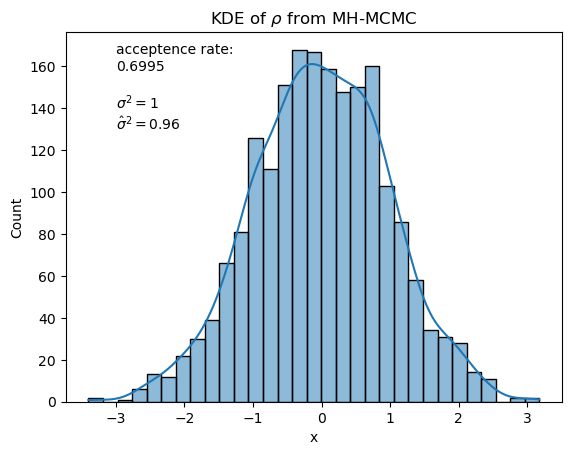

In [ ]:
# PLOT ESTIMATED PDF FROM SAMPLED DISTTRIBUTION
xs = pd.Series(x,name='x') 
sigma_hat = np.mean(x**2)

sns.histplot(data=xs,kde=True)
plt.text(-3,130,f'acceptence rate:\n{accepted}\n\n$\sigma^2 = 1$\n$\hat\sigma^2={sigma_hat:.2f}$')
plt.title(r'KDE of $\rho$ from MH-MCMC');


In [ ]:
# CONVERGENCE OF E[x^2] FOR SEVERAL STARTING VALUES xi
xs = []
sigmas = []
for i in range(5):
    xi = i - 2
    x, accepted, sigma = MCMC(xi=xi,rho=rho,N=2_000,burnin=100,k=5)
    xs.append(x)
    sigmas.append(sigma)

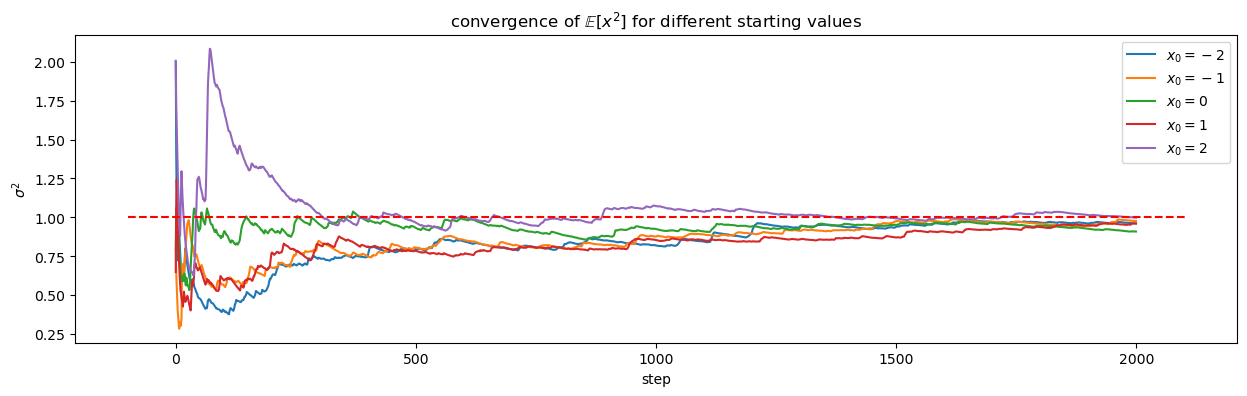

In [ ]:
# PLOT
fig, ax = plt.subplots(figsize=(15,4))

plt.ylabel(r'$\sigma^2$')
plt.xlabel('step')
plt.title(r'convergence of $\mathbb{E}[x^2]$ for different starting values');

for i in range(5):
    ax.plot(sigmas[i],label=f'$x_0 = {i - 2}$')

ax.hlines(y=1,xmin=-100,xmax=len(sigmas[0])+100,color='red',ls='--')
plt.legend()
